# Deep Variational Autoencoder
# For Churn Customer Prediction
## Classification problem of highly unbalanced classes
* The project were written for kaggle Churn prediction competition
* WSDM - KKBox's Churn Prediction Challenge
* https://www.kaggle.com/c/kkbox-churn-prediction-challenge

In [112]:
#from multiprocessing import Pool, cpu_count
#import gc; gc.enable()
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#from sklearn.svm import OneClassSVM
import collections

# For plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

## Read Data
#### train_agg_fet.csv - the train set, of kaggle competition, after feature ingeneering.
* msno: user id
* is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.

In [330]:
test=pd.read_csv('test_with_aggregate_features.csv')
train= pd.read_csv('train_with_aggregate_features.csv')
train = train.fillna(0)
test = test.fillna(0)
train.head()

,msno,is_churn,trans_count,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,...,ag_is_auto_renew,ag_ppp,ag_is_cancel,ag_num_25,ag_num_50,ag_num_75,ag_num_985,ag_num_100,ag_num_unq,ag_total_secs
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.900332,0.0,22.0,4.0,7.0,3.0,152.0,173.0,40919.548
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,19.800664,2.0,0.0,0.0,0.0,0.0,1.0,1.0,281.600
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,9.900332,2.0,22.0,6.0,2.0,10.0,90.0,123.0,23435.342
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,3,40.0,30.0,149.0,149.0,1.0,20170327.0,20170426.0,...,0.0,0.000000,0.0,215.0,68.0,47.0,58.0,334.0,489.0,99840.577
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,9,38.0,90.0,477.0,477.0,0.0,20170225.0,20170528.0,...,0.0,9.900332,0.0,46.0,14.0,10.0,28.0,1383.0,1464.0,349876.794


In [191]:
test=pd.read_csv('vae_test_data.csv')
train= pd.read_csv('vae_train_data.csv')

In [331]:
print train.columns

Index([u'msno', u'is_churn', u'trans_count', u'payment_method_id',
       u'payment_plan_days', u'plan_list_price', u'actual_amount_paid',
       u'is_auto_renew', u'transaction_date', u'membership_expire_date',
       u'is_cancel', u'logs_count', u'date', u'num_25', u'num_50', u'num_75',
       u'num_985', u'num_100', u'num_unq', u'total_secs', u'city', u'bd',
       u'gender', u'registered_via', u'registration_init_time',
       u'trans_2017_count', u'ag_actual_amount_paid', u'ag_is_auto_renew',
       u'ag_ppp', u'ag_is_cancel', u'ag_num_25', u'ag_num_50', u'ag_num_75',
       u'ag_num_985', u'ag_num_100', u'ag_num_unq', u'ag_total_secs'],
      dtype='object')


## Analize data functionality

In [242]:
def agg_col_by_chrn(dfo, col, drow = True):
    
    h = dfo.groupby([col,'is_churn']).agg(len)
    v= h.msno

    dn =pd.DataFrame()
    dn['not'] = v.loc[pd.IndexSlice[:,0]]
    dn['churn']= v.loc[pd.IndexSlice[:,1]]
    dn = dn.fillna(0.)
    if (drow):
        dn.plot(kind='bar', stacked=True, color=['b','y'])
        plt.title(col)
    dn['percent'] = dn.churn * 100. / (dn['not'] +  dn.churn)
    dn['sum'] = dn.churn +(dn['not'])
    dn = dn.sort_values('percent')
    dn = dn.reset_index()
    return dn

In [243]:
def agg_col(dfo, col, drow = True):
    
    h = test.groupby([col,'is_churn']).agg(len)
    v= h.msno

    dn =pd.DataFrame()
    dn['sum'] = v.loc[pd.IndexSlice[:,0]]
    dn = dn.fillna(0.)
    if (drow):
        dn.plot(kind='bar', stacked=True, color=['b','y'])
        plt.title(col)
    dn = dn.reset_index()
    return dn

In [244]:
def drow_col(df, col):
    
    
    dft = train[[col,'is_churn']]
    dft0 = dft[dft.is_churn==0]
    dft1 = dft[dft.is_churn==1]

    sns.kdeplot(dft0[col], label='not churn', shade=True)
    sns.kdeplot(dft1[col], label='churn', shade=True)
    plt.xlabel(col);


## Add New fetures
* Features that can be created easyly, I prefare to create dynamicly and save space on disk.

In [359]:
train['ppp']=10.
test['ppp']=10.
train.loc[train.payment_plan_days>0, 'ppp'] = train['actual_amount_paid']*1. /(train['payment_plan_days'])
test.loc[test.payment_plan_days>0, 'ppp'] = test['actual_amount_paid']*1. / (test['payment_plan_days'])

When viewing this new feture, we can see that its behaving diffrently on the Churned vs. Normal population.

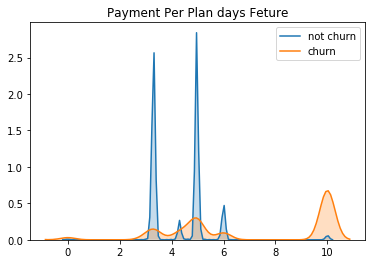

In [360]:
sns.kdeplot(train.ppp[train.is_churn==0], label='not churn', shade=True)
sns.kdeplot(train.ppp[train.is_churn==1], label='churn', shade=True)
plt.title('Payment Per Plan days Feture')

Create another new feture.

In [361]:
train['autorenew_&_not_cancel'] = ((train.is_auto_renew == 1) == (train.is_cancel == 0)).astype(np.int8)
test['autorenew_&_not_cancel'] = ((test.is_auto_renew == 1) == (test.is_cancel == 0)).astype(np.int8)

train['notAutorenew_&_cancel'] = ((train.is_auto_renew == 0) == (train.is_cancel == 1)).astype(np.int8)
test['notAutorenew_&_cancel'] = ((test.is_auto_renew == 0) == (test.is_cancel == 1)).astype(np.int8)

## Handle categorial features
Its best to create dummy categorial fetures, and save disk space and load time.

In [332]:
def order_col_by_churn_percent(col,drow=True):
    
    dn = agg_col_by_chrn(train, col, drow = False)
    tmp = dn[[col]].to_dict()
    val_map=  tmp[col]

    inv_map = {v: k for k, v in val_map.items()}
    print inv_map

    train[col] = train[col].replace(inv_map)
    test[col] = test[col].replace(inv_map)
    if (drow) :
        drow_col(train, col)

### registered_via

In [333]:
col= 'registered_via'
print 'registered_via', collections.Counter(train['registered_via'])

registered_via Counter({7.0: 945410, 9.0: 472309, 0.0: 225763, 3.0: 211904, 4.0: 102027, 13.0: 6478})


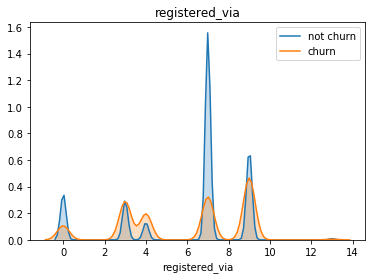

In [334]:
sns.kdeplot(train.registered_via[train.is_churn==0], label='not churn', shade=True)
sns.kdeplot(train.registered_via[train.is_churn==1], label='churn', shade=True)
plt.xlabel('registered_via');
plt.title('registered_via')

{0.0: 1, 3.0: 4, 4.0: 5, 7.0: 0, 9.0: 3, 13.0: 2}


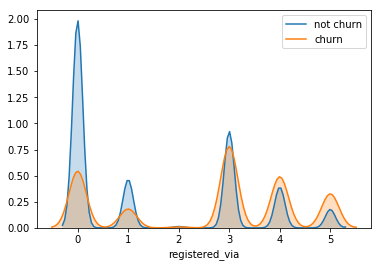

In [335]:
order_col_by_churn_percent(col)

### payment_method_id


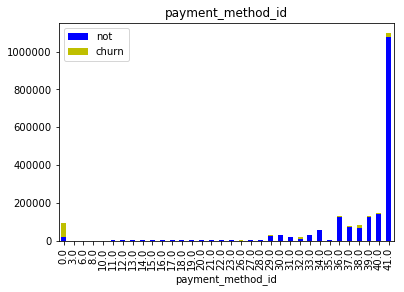

In [336]:
col = 'payment_method_id'
dn = agg_col_by_chrn(train, col)


In [337]:
print 'payment_method_id',collections.Counter(train['payment_method_id'])

payment_method_id Counter({41.0: 1096538, 40.0: 145608, 36.0: 130614, 39.0: 128210, 0.0: 93166, 38.0: 79695, 37.0: 74482, 34.0: 57618, 30.0: 30987, 33.0: 28344, 29.0: 28074, 31.0: 20694, 32.0: 17269, 15.0: 4338, 23.0: 4190, 27.0: 3718, 35.0: 3435, 28.0: 3240, 19.0: 2588, 20.0: 1866, 21.0: 1758, 16.0: 1588, 18.0: 1272, 22.0: 1144, 14.0: 1085, 13.0: 823, 17.0: 616, 12.0: 490, 26.0: 171, 11.0: 150, 10.0: 74, 8.0: 21, 6.0: 14, 3.0: 11})


{0.0: 31, 3.0: 32, 6.0: 30, 8.0: 22, 10.0: 14, 11.0: 9, 12.0: 25, 13.0: 24, 14.0: 2, 15.0: 27, 16.0: 18, 17.0: 33, 18.0: 10, 19.0: 3, 20.0: 26, 21.0: 11, 22.0: 29, 23.0: 5, 26.0: 23, 27.0: 6, 28.0: 20, 29.0: 17, 30.0: 15, 31.0: 0, 32.0: 28, 33.0: 7, 34.0: 1, 35.0: 21, 36.0: 16, 37.0: 4, 38.0: 19, 39.0: 12, 40.0: 13, 41.0: 8}


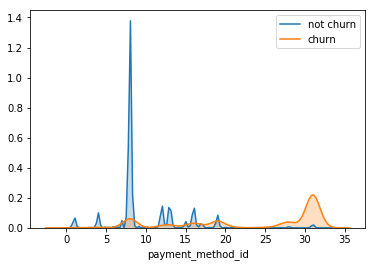

In [338]:
order_col_by_churn_percent(col)

### city

city Counter({1.0: 897987, 0.0: 225763, 13.0: 195417, 5.0: 142005, 4.0: 95172, 15.0: 86543, 22.0: 84120, 6.0: 52088, 14.0: 40180, 12.0: 22937, 9.0: 19084, 11.0: 18174, 18.0: 15634, 8.0: 15279, 10.0: 13003, 17.0: 11022, 21.0: 10485, 3.0: 10146, 7.0: 5318, 16.0: 1900, 20.0: 1354, 19.0: 280})


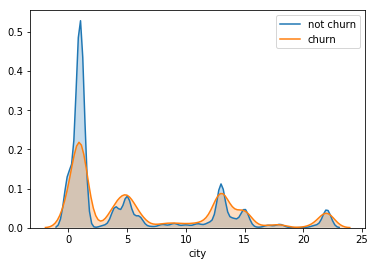

In [339]:
print 'city',collections.Counter(train['city'])
drow_col(train, 'city')

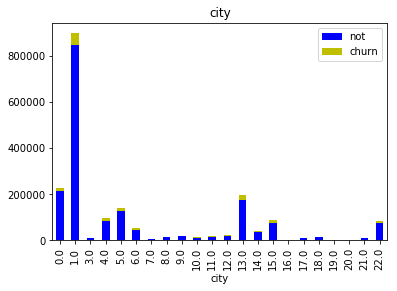

In [340]:
col = 'city'
dn = agg_col_by_chrn(train, col)


{0.0: 0, 1.0: 1, 3.0: 15, 4.0: 16, 5.0: 17, 6.0: 14, 7.0: 3, 8.0: 19, 9.0: 11, 10.0: 18, 11.0: 10, 12.0: 20, 13.0: 9, 14.0: 7, 15.0: 13, 16.0: 5, 17.0: 2, 18.0: 8, 19.0: 6, 20.0: 4, 21.0: 21, 22.0: 12}


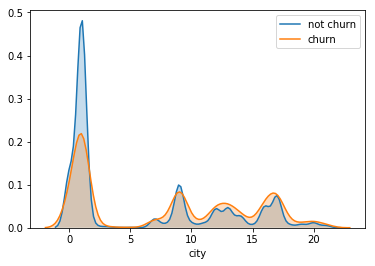

In [341]:
order_col_by_churn_percent(col)

### gender


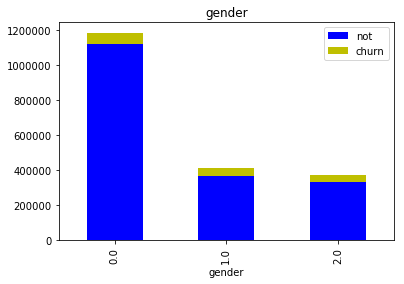

In [342]:
col = 'gender'
dn = agg_col_by_chrn(train, col)

{0.0: 0, 1.0: 2, 2.0: 1}


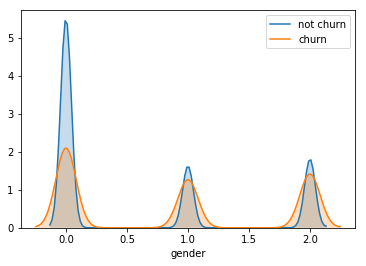

In [343]:
order_col_by_churn_percent('gender')

### Encode Categorial Features
Create dummy feature for each category.
We will not applt this on payment_method_id, becausea there are a lot of values,
and we will get big sparse matrix.

In [344]:
def aply_oonehot(df, col):
    df_en = pd.get_dummies(df[col])
    
    df_en = df_en.drop(df_en.columns[0], 1)
    
    cols = [str(col)+'_'+str(c) for c in df_en.columns]
    df_en.columns = cols
    
    df = df.drop(col, 1)
    
    
    df = pd.concat([df, df_en], axis=1)
    return df

In [345]:
train = aply_oonehot(train, 'city')
test =  aply_oonehot(test, 'city')

train = aply_oonehot(train, 'registered_via')
test =  aply_oonehot(test, 'registered_via')

train = aply_oonehot(train, 'gender')
test =  aply_oonehot(test, 'gender')

In [346]:
print train.columns

Index([u'msno', u'is_churn', u'trans_count', u'payment_method_id',
       u'payment_plan_days', u'plan_list_price', u'actual_amount_paid',
       u'is_auto_renew', u'transaction_date', u'membership_expire_date',
       u'is_cancel', u'logs_count', u'date', u'num_25', u'num_50', u'num_75',
       u'num_985', u'num_100', u'num_unq', u'total_secs', u'bd',
       u'registration_init_time', u'trans_2017_count',
       u'ag_actual_amount_paid', u'ag_is_auto_renew', u'ag_ppp',
       u'ag_is_cancel', u'ag_num_25', u'ag_num_50', u'ag_num_75',
       u'ag_num_985', u'ag_num_100', u'ag_num_unq', u'ag_total_secs',
       u'city_1.0', u'city_2.0', u'city_3.0', u'city_4.0', u'city_5.0',
       u'city_6.0', u'city_7.0', u'city_8.0', u'city_9.0', u'city_10.0',
       u'city_11.0', u'city_12.0', u'city_13.0', u'city_14.0', u'city_15.0',
       u'city_16.0', u'city_17.0', u'city_18.0', u'city_19.0', u'city_20.0',
       u'city_21.0', u'registered_via_1.0', u'registered_via_2.0',
       u'registered_via

## Model evaluation and visualization functions

In [347]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score, log_loss

def print_stats(ytest, ypred):
    
    print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
        accuracy_score(ytest, ypred), 
        cohen_kappa_score(ytest, ypred, weights="quadratic")))
    ll = log_loss(ytest, ypred)
    print("Log Loss: {}".format(ll))
    print ' '
    print("Confusion Matrix:")
    print(confusion_matrix(ytest, ypred))
    print("Classification Report:")
    print(classification_report(ytest, ypred))

In [348]:
def drow_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.title('ROC Curve - Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'g--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show();

In [349]:
def drow_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+ metric])
    plt.title('model '+metric)
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()    

# VAE - variational autoencoder
* refernce: https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/

In [362]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler

XX_train, XX_val = train_test_split(train, test_size=0.2)

cols = [c for c in train.columns if c not in ['is_churn','msno']]

X_train = MinMaxScaler().fit_transform(XX_train[cols])
y_train = XX_train['is_churn'].as_matrix()
X_val = MinMaxScaler().fit_transform(XX_val[cols])
y_val = XX_val['is_churn'].as_matrix()
X_test = MinMaxScaler().fit_transform(test[cols])

Since vae neural net is highly customized, data set size must be devided bt batch size 

In [363]:
def cut_array_to_fit_batchsize(X,y,batch_size):
    n_size = (len(X)//batch_size)*batch_size
    
    X = X[0:n_size]
    
    y = y[0:n_size]
    return X, y

In [364]:
batch_size = 200

X_train, y_train = cut_array_to_fit_batchsize(X_train,y_train, batch_size)
X_val, y_val = cut_array_to_fit_batchsize(X_val, y_val, batch_size)
y_test=np.zeros((len(X_test)))
X_test,y_test = cut_array_to_fit_batchsize(X_test,y_test, batch_size)
print X_val.shape, X_train.shape


(392600, 63) (1571000, 63)


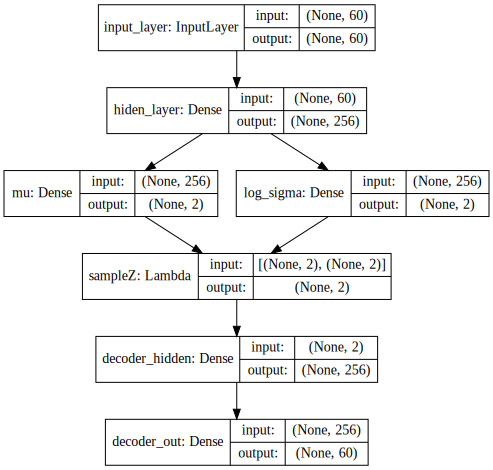

In [354]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping, ModelCheckpoint

import keras.backend as K
from numpy.random import seed
seed(1)

# Define input layer
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,), name='input_layer')

# Define Encoder layers
hiden_layer_dim = 256
hiden_layer = Dense(hiden_layer_dim, activation='relu', 
            name='hiden_layer')(input_layer)

# Create 2 dense layer that outputs latent space dimention data
latent_space_dim = 2
mu = Dense(latent_space_dim, activation='linear', name='mu')(hiden_layer)
log_sigma = Dense(latent_space_dim, activation='linear', name='log_sigma')(hiden_layer)

# Encoder model, to encode input into latent variable
# We choose mu, the mean of the output as can be seen in the samle_z function.
# the mean is the center point, the representative of the gaussian
encoder = Model(input_layer, mu, name='encoder')

# Now the trick of the vae, to sample from the 2 dense layers
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(batch_size, latent_space_dim), mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2) * eps


# Sample from the output of the 2 dense layers
sampleZ = Lambda(sample_z, name='sampleZ', output_shape=(latent_space_dim,))([mu, log_sigma])

# Define decoder layers in VAE model
decoder_hidden = Dense(hiden_layer_dim, activation='relu', name='decoder_hidden') 
decoder_out = Dense(input_dim, activation='sigmoid', name = 'decoder_out')

h_p = decoder_hidden(sampleZ)
output_layer = decoder_out(h_p)

# VAE model, Unsupervised leraning for reconstruction of the input data
vae = Model(input_layer, output_layer, name='vae')


# Define a separate Decoder model, that recostruct data from latent variable 
# The decoder model uses eights that was trained with the VAE mode;,
# We need a separate model, if we want to generate data from given data in latent space.
d_in = Input(shape=(latent_space_dim,), name='decoder_input')
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)

decoder = Model(d_in, d_out, name='decoder')

SVG(model_to_dot(vae, show_shapes='true').create(prog='dot', format='svg'))

In [355]:
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)

    return recon + kl

In [366]:

vae.compile(optimizer='adam', loss=vae_loss)
vae_history = vae.fit(X_train, X_train, batch_size=batch_size, shuffle=True, 
                      validation_data = (X_val, X_val),
                    epochs=50)

Train on 1571000 samples, validate on 392600 samples
Epoch 1/50
1571000/1571000 [==============================] - 62s - loss: 11.3600 - val_loss: 11.2433
Epoch 2/50
1571000/1571000 [==============================] - 70s - loss: 10.8086 - val_loss: 11.1048
Epoch 3/50
1571000/1571000 [==============================] - 67s - loss: 10.7314 - val_loss: 11.0566
Epoch 4/50
1571000/1571000 [==============================] - 70s - loss: 10.7044 - val_loss: 11.0641
Epoch 5/50
1571000/1571000 [==============================] - 75s - loss: 10.6879 - val_loss: 11.0202
Epoch 6/50
1571000/1571000 [==============================] - 69s - loss: 10.6757 - val_loss: 11.0076
Epoch 7/50
1571000/1571000 [==============================] - 73s - loss: 10.6660 - val_loss: 10.9903
Epoch 8/50
1571000/1571000 [==============================] - 76s - loss: 10.6566 - val_loss: 10.9925
Epoch 9/50
1571000/1571000 [==============================] - 58s - loss: 10.6446 - val_loss: 10.9735
Epoch 10/50
1571000/1571000 [

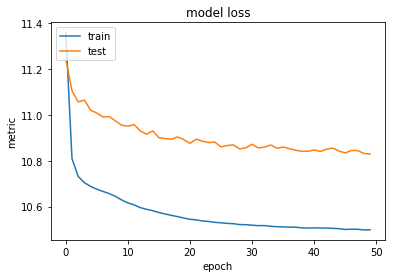

In [367]:
drow_history(vae_history, 'loss')

## Lets view the data set in Latent space
Intuitivly, we can hope that the difference in the Churn vs Normal population will be seen in the latent space, and enable us to reduce our classification problem to a simple 2D classification.

(1571000, 2) (1571000,) (1571000,) (1571000, 63)


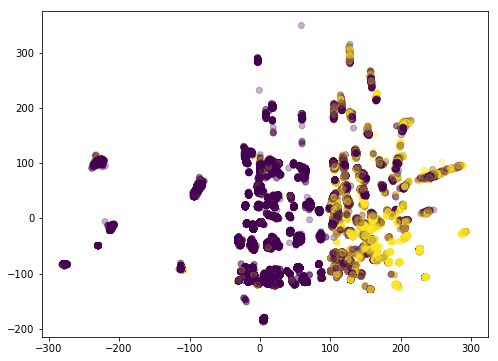

In [368]:

x_train_encoded = encoder.predict(X_train)

print x_train_encoded.shape, x_train_encoded[:, 0].shape, x_train_encoded[:, 1].shape, X_train.shape

#color_bar.set_alpha(1)
plt.figure(figsize=(8, 6))
plt.scatter(100.*x_train_encoded[:, 0], 100.*x_train_encoded[:, 1], 
            c=y_train, alpha=0.3)

plt.show()

### Classification of Churn in the latent space
* We can see that Churn and normal population are separable in the latent space. For example, Lets run Nearest neighbour classification on it.

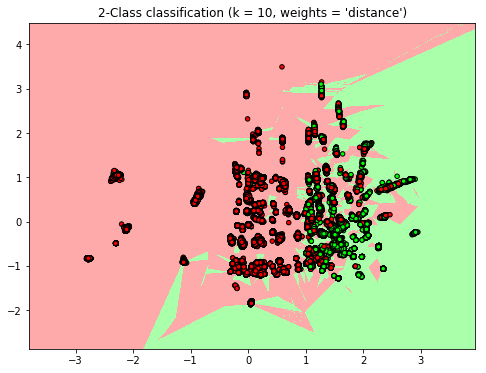

In [429]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
weights='distance'
n_neighbors=10
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
X=x_train_encoded
y=y_train
clf.fit(X, y)

h = .002  # step size in the mesh
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("2-Class classification (k = %i, weights = '%s')"
            % (n_neighbors, weights))

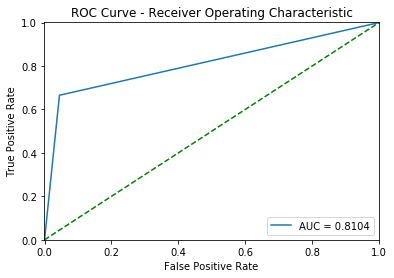

Accuracy: 0.93317, Cohen's Kappa Score: 0.56833
Log Loss: 2.3083949835
 
Confusion Matrix:
[[346309  16154]
 [ 10085  20052]]
Classification Report:
             precision    recall  f1-score   support

          0       0.97      0.96      0.96    362463
          1       0.55      0.67      0.60     30137

avg / total       0.94      0.93      0.94    392600



In [430]:
x_val_encoded = encoder.predict(X_val)

y_val_neibghour = clf.predict(x_val_encoded)
drow_roc_curve(y_val, y_val_neibghour)

print_stats(y_val, y_val_neibghour)

## Classification of churn customers by reconstruction error
* We can hope that the reconstruction error, will behave differently in the Churn vs Normal population. Lets try and classify by the recostruction error.

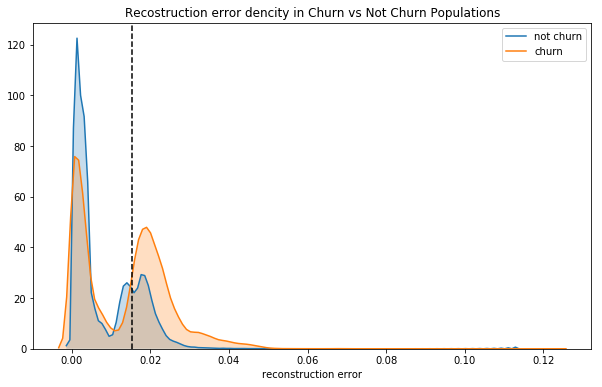

In [390]:
x_train_encoded = encoder.predict(X_train)

pred_train = decoder.predict(x_train_encoded)
mse = np.mean(np.power(X_train - pred_train, 2), axis=1)
error_df = pd.DataFrame({'recon_error': mse,
                        'churn': y_train})

plt.figure(figsize=(10,6))
sns.kdeplot(error_df.recon_error[error_df.churn==0], label='not churn', shade=True, clip=(0,10))
sns.kdeplot(error_df.recon_error[error_df.churn==1], label='churn', shade=True, clip=(0,10))
plt.xlabel('reconstruction error');
plt.axvline(x=0.0154, color='k', linestyle='--')
plt.title('Recostruction error dencity in Churn vs Not Churn Populations')

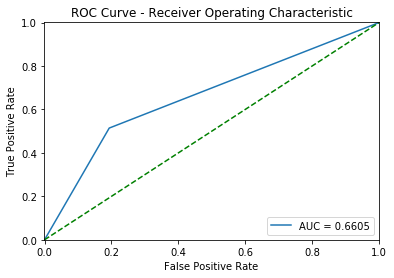

Accuracy: 0.78416, Cohen's Kappa Score: 0.17408
Log Loss: 7.45483532337
 
Confusion Matrix:
[[292362  70101]
 [ 14636  15501]]
Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.81      0.87    362463
          1       0.18      0.51      0.27     30137

avg / total       0.89      0.78      0.83    392600



In [427]:
x_val_encoded = encoder.predict(X_val)

pred = decoder.predict(x_val_encoded)
mse = np.mean(np.power(X_val - pred, 2), axis=1)
error_df = pd.DataFrame({'recon_error': mse
                        })
threshold=0.0154
y_val_pred = [1 if (e > threshold ) else 0 for e in error_df.recon_error]
drow_roc_curve(y_val, y_val_pred)

print_stats(y_val, y_val_pred)

### We can not classify by viewing the population distribution in the Validation data set. But we can view the distribution just for checking our assumtion that we can classify by reconstruction error.

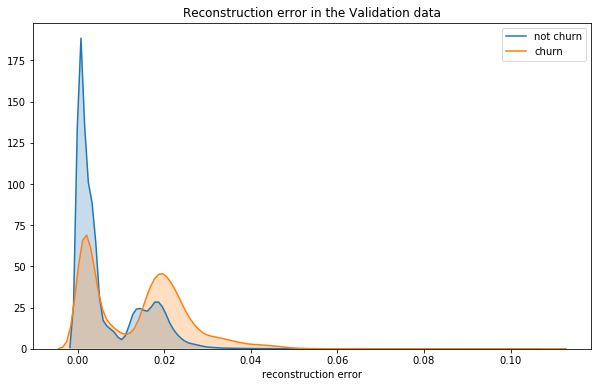

In [432]:
x_val_encoded = encoder.predict(X_val)

pred = decoder.predict(x_val_encoded)

mse = np.mean(np.power(X_val - pred, 2), axis=1)
error_df = pd.DataFrame({'recon_error': mse,
                        'churn': y_val})

plt.figure(figsize=(10,6))
sns.kdeplot(error_df.recon_error[error_df.churn==0], label='not churn', shade=True, clip=(0,10))
sns.kdeplot(error_df.recon_error[error_df.churn==1], label='churn', shade=True, clip=(0,10))
plt.xlabel('reconstruction error');
plt.title('Reconstruction error in the Validation data')